In [1]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_impact_of_lmbda_runs(acq):
    runs = api.runs(path="ziv-scully-group/PandoraBayesOPT", filters={
        "sweep": "xcn0phan",
        "config.amplitude": 1,
        "config.dim": 8,
        "config.kernel": "Matern52",
        "config.lengthscale": 0.1,  
        "config.policy": acq})
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["cumulative cost","best observed","acq"]
        history = run.scan_history(keys = metric_keys, page_size=1_000_000_000)
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        summary_metric_keys = ["global optimum value"]
        summary_history = run.scan_history(keys = summary_metric_keys, page_size=1_000_000_000)
        metrics.update({k: [d[k] for d in summary_history] for k in summary_metric_keys})
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [2]:
acquisition_functions = [
    'Gittins_Lambda_01',
    'Gittins_Lambda_001',
    'Gittins_Lambda_0001',
    'Gittins_Lambda_00001'
]

In [3]:
grouped_runs = {(a): load_impact_of_lmbda_runs(a) for a in acquisition_functions}

100%|██████████| 256/256 [07:15<00:00,  1.70s/it]


In [17]:
# Initialize dictionaries
cumulative_cost_per_acq = {}
current_best_per_acq = {}
acq_values_per_acq = {}
global_optimum_per_acq = {}
regret_per_acq = {}

for a in acquisition_functions:
    config_and_metrics_per_seed = grouped_runs[a]

    # Extract metrics along with the seeds for sorting
    seeds_and_metrics = [
        (config['seed'], m['cumulative cost'], m['best observed'], m['acq'], m['global optimum value'])
        for config, m in config_and_metrics_per_seed
        if len(m['best observed']) > 0
    ]

    # Sort by seed
    seeds_and_metrics.sort(key=lambda x: x[0])

    # Extract and organize sorted metrics
    cumulative_cost_per_seed = np.array([item[1] for item in seeds_and_metrics])
    best_observed_per_seed = np.array([item[2] for item in seeds_and_metrics], dtype=float)
    acq_per_seed = np.array([item[3] for item in seeds_and_metrics], dtype=float)
    global_optimum_per_seed = np.array([item[4] for item in seeds_and_metrics])

    regret_per_seed = global_optimum_per_seed[:, 0][:, None] - best_observed_per_seed

    # Save into dictionaries
    cumulative_cost_per_acq[a] = cumulative_cost_per_seed
    current_best_per_acq[a] = best_observed_per_seed
    acq_values_per_acq[a] = acq_per_seed
    global_optimum_per_acq[a] = global_optimum_per_seed
    regret_per_acq[a] = regret_per_seed

    print(a, regret_per_seed.shape)

Gittins_Lambda_01 (256, 200)
Gittins_Lambda_001 (256, 200)
Gittins_Lambda_0001 (256, 200)
Gittins_Lambda_00001 (256, 200)


In [23]:
import pickle

# Group all dictionaries together
all_data = {
    'cumulative_cost_per_acq': cumulative_cost_per_acq,
    'current_best_per_acq': current_best_per_acq,
    'acq_values_per_acq': acq_values_per_acq,
    'global_optimum_per_acq': global_optimum_per_acq,
    'regret_per_acq': regret_per_acq
}

# Save
with open('lambda_impact_256_metrics_per_acq.pkl', 'wb') as f:
    pickle.dump(all_data, f)

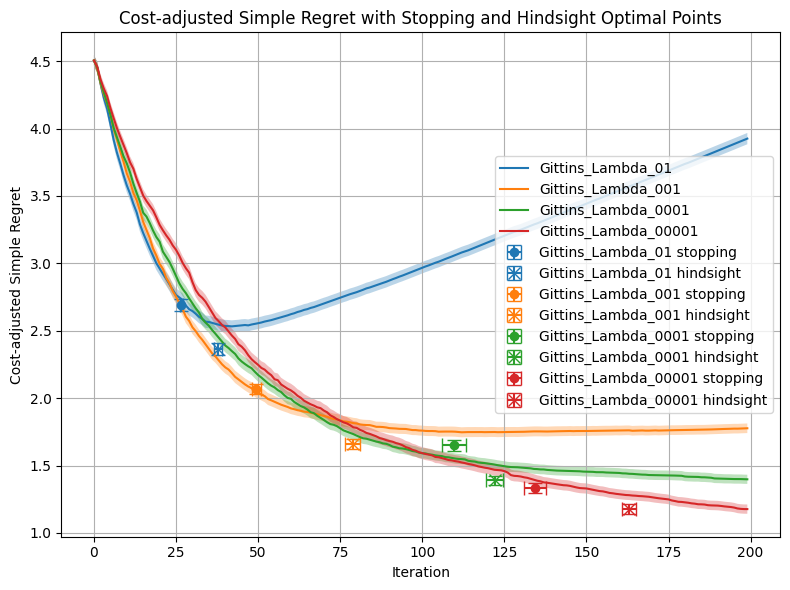

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

lambda_per_acq = {
    'Gittins_Lambda_01': 0.01,
    'Gittins_Lambda_001': 0.001,
    'Gittins_Lambda_0001': 0.0001,
    'Gittins_Lambda_00001': 0.00001
}

plt.figure(figsize=(8, 6))

for a in acquisition_functions:
    lmbda = lambda_per_acq[a]
    
    regret = regret_per_acq[a]
    cumulative_cost = cumulative_cost_per_acq[a]
    acq = acq_values_per_acq[a]
    best_observed = current_best_per_acq[a]

    # Compute cost-adjusted regret curve
    cost_adjusted_regret = regret + lmbda * cumulative_cost

    # Mean and standard error over seeds
    mean_curve = cost_adjusted_regret.mean(axis=0)
    stderr_curve = cost_adjusted_regret.std(axis=0) / np.sqrt(cost_adjusted_regret.shape[0])

    # Plot mean curve and fill error bars
    plt.plot(mean_curve, label=a)
    plt.fill_between(np.arange(len(mean_curve)),
                     mean_curve - stderr_curve,
                     mean_curve + stderr_curve,
                     alpha=0.3)

    # === 1. Compute *actual* stopping point based on acq < best observed after 20 iterations ===
    stopping_times = []
    stopping_cost_adjusted_regrets = []

    # === 2. Compute *hindsight* best point: minimum cost-adjusted regret ===
    hindsight_best_times = []
    hindsight_best_regrets = []

    n_seeds = regret.shape[0]

    for seed_idx in range(n_seeds):
        acq_seed = acq[seed_idx]
        best_obs_seed = best_observed[seed_idx]

        # Actual stopping point
        valid_indices = np.where((acq_seed < best_obs_seed) & (np.arange(len(acq_seed)) >= 20))[0]
        if len(valid_indices) == 0:
            i_stop = len(acq_seed) - 1
        else:
            i_stop = valid_indices[0]

        stopping_times.append(i_stop)
        cost_adj_regret_at_stop = cost_adjusted_regret[seed_idx, i_stop]
        stopping_cost_adjusted_regrets.append(cost_adj_regret_at_stop)

        # Hindsight best point (over all iterations)
        i_best = np.argmin(cost_adjusted_regret[seed_idx])
        hindsight_best_times.append(i_best)
        hindsight_best_regrets.append(cost_adjusted_regret[seed_idx, i_best])

    # Convert to arrays
    stopping_times = np.array(stopping_times)
    stopping_cost_adjusted_regrets = np.array(stopping_cost_adjusted_regrets)
    hindsight_best_times = np.array(hindsight_best_times)
    hindsight_best_regrets = np.array(hindsight_best_regrets)

    # Compute mean and stderr for stopping points
    mean_stopping_time = stopping_times.mean()
    stderr_stopping_time = stopping_times.std() / np.sqrt(n_seeds)

    mean_stopping_cost_adjusted_regret = stopping_cost_adjusted_regrets.mean()
    stderr_stopping_cost_adjusted_regret = stopping_cost_adjusted_regrets.std() / np.sqrt(n_seeds)

    # Compute mean and stderr for hindsight best points
    mean_hindsight_time = hindsight_best_times.mean()
    stderr_hindsight_time = hindsight_best_times.std() / np.sqrt(n_seeds)

    mean_hindsight_regret = hindsight_best_regrets.mean()
    stderr_hindsight_regret = hindsight_best_regrets.std() / np.sqrt(n_seeds)

    # Get color for current curve
    color = plt.gca().lines[-1].get_color()

    # Plot actual stopping "+" (mean ± stderr)
    plt.errorbar(mean_stopping_time,
                 mean_stopping_cost_adjusted_regret,
                 xerr=stderr_stopping_time,
                 yerr=stderr_stopping_cost_adjusted_regret,
                 fmt='o', color=color, capsize=5, markersize=6, label=f'{a} stopping')

    # Plot hindsight optimal "+" (mean ± stderr), dashed circle
    plt.errorbar(mean_hindsight_time,
                 mean_hindsight_regret,
                 xerr=stderr_hindsight_time,
                 yerr=stderr_hindsight_regret,
                 fmt='x', color=color, capsize=5, markersize=8, label=f'{a} hindsight')

plt.xlabel('Iteration')
plt.ylabel('Cost-adjusted Simple Regret')
plt.title('Cost-adjusted Simple Regret with Stopping and Hindsight Optimal Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()